In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [125]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

In [5]:
all_trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'rewarded_modality', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_instruction',
       'is_aud_stim', 'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_rewarded', 'is_aud_rewarded', 'is_block_switch', 'is_repeat',
       'is_opto', 'session_idx', 'date', 'subject_id', 's

In [126]:
# select 2 columns to find correlation between
col1='is_correct'
col2='is_vis_rewarded'

# set trial filter
# trial_query = '~is_rewarded and is_target'
trial_query='is_target and is_response'

if len(trial_query)>0:
    trials_filtered=all_trials.query(trial_query+' and session_id in @dr_session_list')
else:
    trials_filtered=all_trials.query('session_id in @dr_session_list')

corr, pval = stats.pearsonr(trials_filtered[col1].values.astype(int), trials_filtered[col2].values.astype(int))
print(f'Correlation between {col1} and {col2}: {corr}, p={pval}')

Correlation between is_correct and is_vis_rewarded: 0.049903905061999786, p=3.0064271821636764e-10


In [111]:
all_trials['response_or_reward_time']=all_trials[['response_time','reward_time']].min(axis=1, skipna=True)
all_trials['is_response_or_reward']=all_trials['response_time'].notna() | all_trials['reward_time'].notna()

In [ ]:
all_trials.query('is_instruction and ~is_response')['response_or_reward_time']

0.0

In [123]:
all_trials.with_columns(
    pl.min_horizontal('response_time','reward_time').alias('response_or_reward_time'),
    (pl.col('response_time').is_not_null() | pl.col('reward_time').is_not_null()).alias('is_response_or_reward')
)

start_time,stop_time,quiescent_start_time,quiescent_stop_time,stim_start_time,stim_stop_time,response_window_start_time,response_window_stop_time,task_control_response_time,response_time,reward_time,post_response_window_start_time,post_response_window_stop_time,stim_name,block_index,rewarded_modality,trial_index,trial_index_in_block,repeat_index,is_response,is_correct,is_incorrect,is_hit,is_false_alarm,is_correct_reject,is_miss,is_go,is_nogo,is_rewarded,is_noncontingent_reward,is_contingent_reward,is_reward_scheduled,is_instruction,is_aud_stim,is_vis_stim,is_catch,is_target,is_aud_target,is_vis_target,is_nontarget,is_aud_nontarget,is_vis_nontarget,is_vis_rewarded,is_aud_rewarded,is_block_switch,is_repeat,is_opto,session_idx,date,subject_id,session_id,id,response_or_reward_time,is_response_or_reward
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,str,i64,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,i64,date,i64,str,i64,f64,bool
111.21154,115.71493,111.21154,112.67913,112.743143,113.243513,112.7959,113.71331,113.49646,113.4812,112.81258,113.743973,115.745643,"""vis1""",0,"""vis""",0,0.0,0.0,true,true,false,true,false,false,false,true,false,true,true,false,true,true,false,true,false,true,false,true,false,false,false,true,false,false,false,false,0,2022-07-26,620263,"""620263_2022-07-26""",0,112.81258,true
116.09859,120.60244,116.09859,117.56693,117.630427,118.631277,117.68333,118.60065,118.00018,117.98803,117.7,118.631277,120.632947,"""vis1""",0,"""vis""",1,1.0,0.0,true,true,false,true,false,false,false,true,false,true,true,false,true,true,false,true,false,true,false,true,false,false,false,true,false,false,false,false,0,2022-07-26,620263,"""620263_2022-07-26""",1,117.7,true
120.78591,125.2896,120.78591,122.25374,122.317773,122.818193,122.3705,123.28794,122.68746,122.67801,122.38722,123.318603,125.320283,"""vis1""",0,"""vis""",2,2.0,0.0,true,true,false,true,false,false,false,true,false,true,true,false,true,true,false,true,false,true,false,true,false,false,false,true,false,false,false,false,0,2022-07-26,620263,"""620263_2022-07-26""",2,122.38722,true
126.04027,130.544,126.04027,127.50818,127.572087,128.572927,127.62494,128.54233,127.90852,127.90397,127.64157,128.572927,130.574587,"""vis1""",0,"""vis""",3,3.0,0.0,true,true,false,true,false,false,false,true,false,true,true,false,true,true,false,true,false,true,false,true,false,false,false,true,false,false,false,false,0,2022-07-26,620263,"""620263_2022-07-26""",3,127.64157,true
130.66081,135.16464,130.66081,132.12864,132.192693,132.693103,132.24554,133.1629,132.5123,132.5088,132.26233,133.193533,135.195183,"""vis1""",0,"""vis""",4,4.0,0.0,true,true,false,true,false,false,false,true,false,true,true,false,true,true,false,true,false,true,false,true,false,false,false,true,false,false,false,false,0,2022-07-26,620263,"""620263_2022-07-26""",4,132.26233,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3605.078374,3610.582973,3605.078374,3606.546291,3606.579627,3607.080054,3606.663068,3607.580491,null,null,null,3607.580491,3610.582973,"""vis2""",5,"""aud""",547,86.0,0.0,false,true,false,false,false,true,false,false,true,false,false,false,false,false,false,true,false,false,false,false,true,false,true,false,true,false,false,false,0,2025-03-19,780329,"""780329_2025-03-19""",547,null,false
3614.586312,3620.140978,3614.586312,3616.054205,3616.087577,3616.588015,3616.170973,3617.088429,null,null,null,3617.088429,3620.140978,"""vis2""",5,"""aud""",548,87.0,0.0,false,true,false,false,false,true,false,false,true,false,false,false,false,false,false,true,false,false,false,false,true,false,true,false,true,false,false,false,0,2025-03-19,780329,"""780329_2025-03-19""",548,null,false
3621.775658,3627.280278,3621.775658,3623.243573,3623.276928,3623.276928,3623.360338,3624.277775,null,null,null,3624.277775,3627.280278,"""catch""",5,""

In [41]:
#no trial filter comparisons

trial_filter_dict={
    'all trials':'',
    'visual stimulus trials':'is_vis_stim',
    'auditory stimulus trials':'is_aud_stim',
    'target trials':'is_target',
    'non-rewarded trials':'~is_rewarded',
    'response trials':'is_response',
}

comp_results={
    'filter_name':[],
    'col1':[],
    'col2':[],
    'corr':[],
    'pval':[],
    'n_trials':[],
}

# comps=[
#     ('is_vis_rewarded','is_response'),
#     ('is_vis_rewarded','is_vis_target'),
#     ('is_aud_rewarded','is_aud_target'),
#     ('is_response','is_vis_target'),
#     ('is_response','is_aud_target'),
# ]

#all comps
comps=[
    ('is_vis_rewarded','is_response'),
    ('is_vis_rewarded','is_vis_target'),
    ('is_vis_rewarded','is_aud_target'),
    ('is_response','is_vis_target'),
    ('is_response','is_aud_target'),
    ('is_vis_target','is_aud_target'),
]

for filter_name,trial_query in trial_filter_dict.items():
    print(f'\nTrial filter: {filter_name} ({trial_query})')
    if len(trial_query)>0:
        trials_filtered=all_trials.query(trial_query+' and session_id in @dr_session_list')
    else:
        trials_filtered=all_trials.query('session_id in @dr_session_list')
    print(f'Number of trials: {len(trials_filtered)}')

    for col1,col2 in comps:
        corr, pval = stats.pearsonr(trials_filtered[col1].values.astype(int), trials_filtered[col2].values.astype(int))
        print(f'Correlation between {col1} and {col2}: {corr}, p={pval}')

        comp_results['filter_name'].append(filter_name)
        comp_results['col1'].append(col1)
        comp_results['col2'].append(col2)
        comp_results['corr'].append(corr)
        comp_results['pval'].append(pval)
        comp_results['n_trials'].append(len(trials_filtered))
    
comp_results_df=pd.DataFrame(comp_results)
comp_results_df


Trial filter: all trials ()
Number of trials: 48821
Correlation between is_vis_rewarded and is_response: -0.07197549296990381, p=4.348153653403136e-57
Correlation between is_vis_rewarded and is_vis_target: 0.06600172705747867, p=2.852424276220904e-48
Correlation between is_vis_rewarded and is_aud_target: -0.06749058477835912, p=2.134230487925708e-50
Correlation between is_response and is_vis_target: 0.35670161956987656, p=0.0
Correlation between is_response and is_aud_target: 0.30775131117516286, p=0.0
Correlation between is_vis_target and is_aud_target: -0.31607181367263326, p=0.0

Trial filter: visual stimulus trials (is_vis_stim)
Number of trials: 21979
Correlation between is_vis_rewarded and is_response: 0.33414856174579644, p=0.0
Correlation between is_vis_rewarded and is_vis_target: 0.057157719034345994, p=2.2468443576743562e-17
Correlation between is_vis_rewarded and is_aud_target: nan, p=nan
Correlation between is_response and is_vis_target: 0.639103879259877, p=0.0
Correlatio

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18964\741479708.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(trials_filtered[col1].values.astype(int), trials_filtered[col2].values.astype(int))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18964\741479708.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(trials_filtered[col1].values.astype(int), trials_filtered[col2].values.astype(int))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_18964\741479708.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = stats.pearsonr(trials_filtered[col1].values.astype(int), trials_filtered[col2].values.astype(int))


,filter_name,col1,col2,corr,pval,n_trials
0,all trials,is_vis_rewarded,is_response,-0.071975,4.348154e-57,48821
1,all trials,is_vis_rewarded,is_vis_target,0.066002,2.852424e-48,48821
2,all trials,is_vis_rewarded,is_aud_target,-0.067491,2.134230e-50,48821
3,all trials,is_response,is_vis_target,0.356702,0.000000e+00,48821
4,all trials,is_response,is_aud_target,0.307751,0.000000e+00,48821
5,all trials,is_vis_target,is_aud_target,-0.316072,0.000000e+00,48821
6,visual stimulus trials,is_vis_rewarded,is_response,0.334149,0.000000e+00,21979
7,visual stimulus trials,is_vis_rewarded,is_vis_target,0.057158,2.246844e-17,21979
8,visual stimulus trials,is_vis_rewarded,is_aud_target,NaN,NaN,21979
9,visual stimulus trials,is_response,is_vis_target,0.639104,0.000000e+00,21979


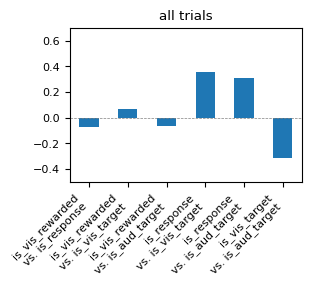

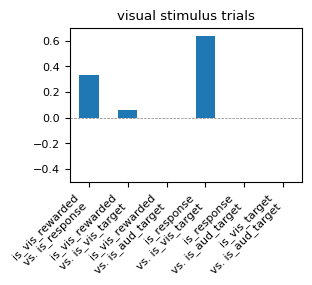

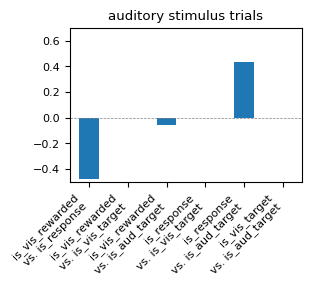

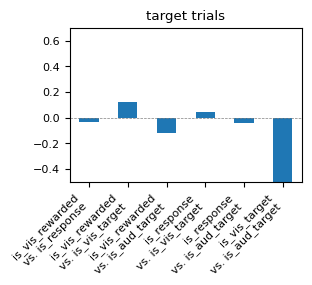

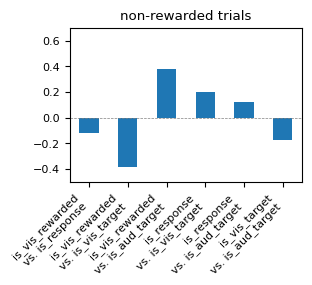

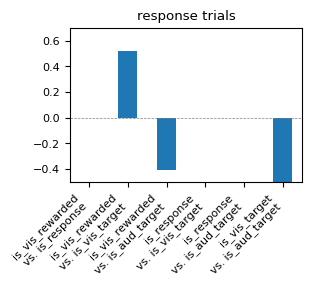

In [42]:
for filter_name in comp_results_df['filter_name'].unique():
    df_sub=comp_results_df.query('filter_name==@filter_name')
    fig,ax=plt.subplots(figsize=(3,2))
    ax.axhline(0, color='gray', lw=0.5, ls='--')
    df_sub.plot.bar(y='corr',ax=ax,legend=False)
    x_labels=[f"{r['col1']}\nvs. {r['col2']}" for i,r in df_sub.iterrows()]
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_ylim(-0.5,0.7)
    ax.set_title(filter_name)

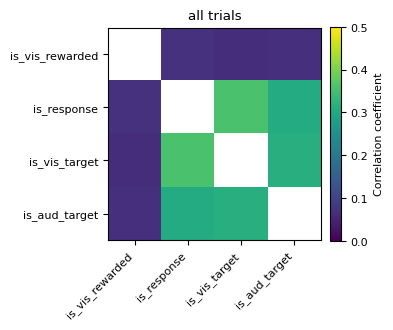

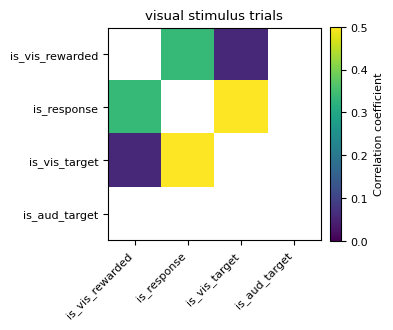

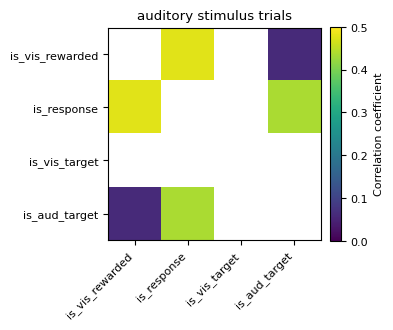

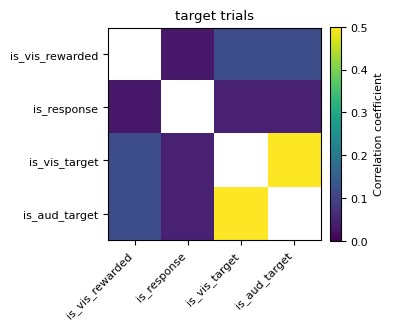

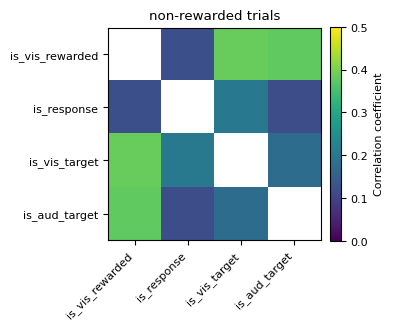

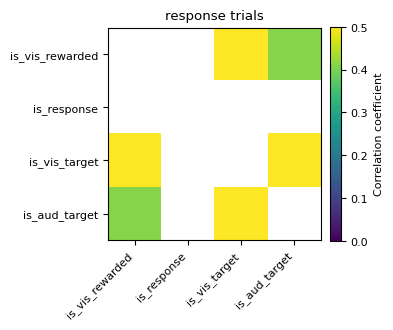

In [51]:
var_list=['is_vis_rewarded','is_response','is_vis_target','is_aud_target']
#plot heatmap
for filter_name in comp_results_df['filter_name'].unique():
    df_sub=comp_results_df.query('filter_name==@filter_name')
    correlation_matrix=pd.DataFrame(index=var_list, columns=var_list, data=np.nan)
    for row in var_list:
        for col in var_list:
            if row==col:
                correlation_matrix.loc[row,col]=np.nan
            else:
                correlation_matrix.loc[row,col] = df_sub.query('(col1==@row and col2==@col) or (col1==@col and col2==@row)')['corr'].values[0]
    fig,ax=plt.subplots(figsize=(3,3))
    im=ax.imshow(np.abs(correlation_matrix), vmin=0, vmax=0.5, cmap='viridis')
    ax.set_xticks(np.arange(correlation_matrix.shape[1]))
    ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(correlation_matrix.shape[0]))
    
    ax.set_yticklabels(correlation_matrix.index)
    ax.set_title(filter_name)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Correlation coefficient')


In [50]:
correlation_matrix

,is_response,is_vis_target,is_aud_target,is_vis_rewarded
is_vis_rewarded,NaN,0.515737,-0.409883,NaN
is_response,NaN,NaN,NaN,NaN
is_vis_target,NaN,NaN,-0.716715,0.515737
is_aud_target,NaN,-0.716715,NaN,-0.409883


In [ ]:
sel_session="664851_2023-11-13"
session_trials = all_trials.query('session_id == @sel_session and is_response and is_vis_stim')
balance_column = 'is_vis_rewarded'

#choose an equal number of correct and incorrect trials
n_true = session_trials[balance_column].sum()
n_false = (~session_trials[balance_column]).sum()
n = min(n_true, n_false)

correct_indices = session_trials[session_trials[balance_column]].index
incorrect_indices = session_trials[~session_trials[balance_column]].index

# Randomly sample from the correct and incorrect indices
correct_sample = correct_indices.to_series().sample(n=n).values
incorrect_sample = incorrect_indices.to_series().sample(n=n).values

resampled_trials = all_trials.loc[np.hstack([correct_sample, incorrect_sample])]

(array([ 1.,  1.,  4.,  1.,  2.,  1.,  5.,  4., 14., 16., 15.,  5.,  3.,
         4.,  1.,  2.,  3.,  1.,  0.,  1.]),
 array([0.14680396, 0.18102756, 0.21525117, 0.24947477, 0.28369837,
        0.31792198, 0.35214558, 0.38636919, 0.42059279, 0.4548164 ,
        0.48904   , 0.5232636 , 0.55748721, 0.59171081, 0.62593442,
        0.66015802, 0.69438163, 0.72860523, 0.76282883, 0.79705244,
        0.83127604]),
 <BarContainer object of 20 artists>)

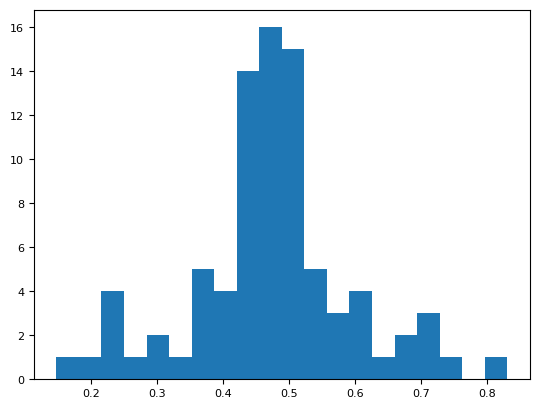

In [91]:
dist = session_trials['response_time'].values - session_trials['stim_start_time'].values

fig,ax=plt.subplots()
ax.hist(dist, bins=20)

# n_false

(array([18., 35., 91., 97., 51., 19., 16., 16., 14., 16., 14.,  7.,  3.,
         2.,  3.,  1.,  2.,  0.,  0.,  3.]),
 array([0.16436  , 0.2036695, 0.242979 , 0.2822885, 0.321598 , 0.3609075,
        0.400217 , 0.4395265, 0.478836 , 0.5181455, 0.557455 , 0.5967645,
        0.636074 , 0.6753835, 0.714693 , 0.7540025, 0.793312 , 0.8326215,
        0.871931 , 0.9112405, 0.95055  ]),
 <BarContainer object of 20 artists>)

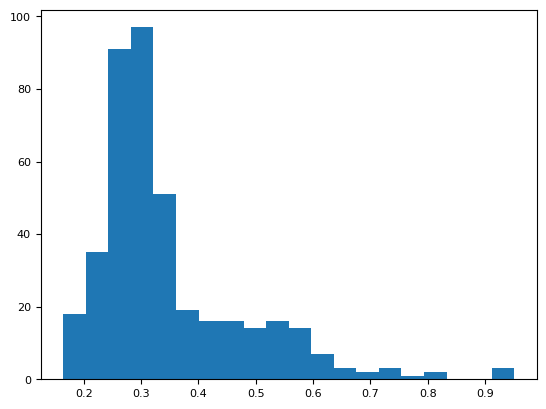

In [103]:
mouse_trials=all_trials.query('session_id.str.contains("664851") and is_response and is_aud_stim')

dist = mouse_trials['response_time'].values - mouse_trials['stim_start_time'].values

fig,ax=plt.subplots()
ax.hist(dist, bins=20)